In [701]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/titanic/train.csv
/kaggle/input/titanic/test.csv
/kaggle/input/titanic/gender_submission.csv


In [702]:
train_set = pd.read_csv('/kaggle/input/titanic/train.csv')
x_test = pd.read_csv('/kaggle/input/titanic/test.csv')
train_set.head(10)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
5,6,0,3,"Moran, Mr. James",male,NaN,0,0,330877,8.4583,NaN,Q
6,7,0,1,"McCarthy, Mr. Timothy J",male,54.0,0,0,17463,51.8625,E46,S
7,8,0,3,"Palsson, Master. Gosta Leonard",male,2.0,3,1,349909,21.0750,NaN,S
8,9,1,3,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",female,27.0,0,2,347742,11.1333,NaN,S
9,10,1,2,"Nasser, Mrs. Nicholas (Adele Achem)",female,14.0,1,0,237736,30.0708,NaN,C


In [703]:
train_set.set_index('PassengerId',inplace=True)
x_test.set_index('PassengerId',inplace=True)

In [704]:
# Show missing values in training set
print(train_set.isnull().sum())
# Show missing values in test set
print(x_test.isnull().sum())

Survived      0
Pclass        0
Name          0
Sex           0
Age         177
SibSp         0
Parch         0
Ticket        0
Fare          0
Cabin       687
Embarked      2
dtype: int64
Pclass        0
Name          0
Sex           0
Age          86
SibSp         0
Parch         0
Ticket        0
Fare          1
Cabin       327
Embarked      0
dtype: int64


(891, 11)
Survived      int64
Pclass        int64
Name         object
Sex          object
Age         float64
SibSp         int64
Parch         int64
Ticket       object
Fare        float64
Cabin        object
Embarked     object
dtype: object


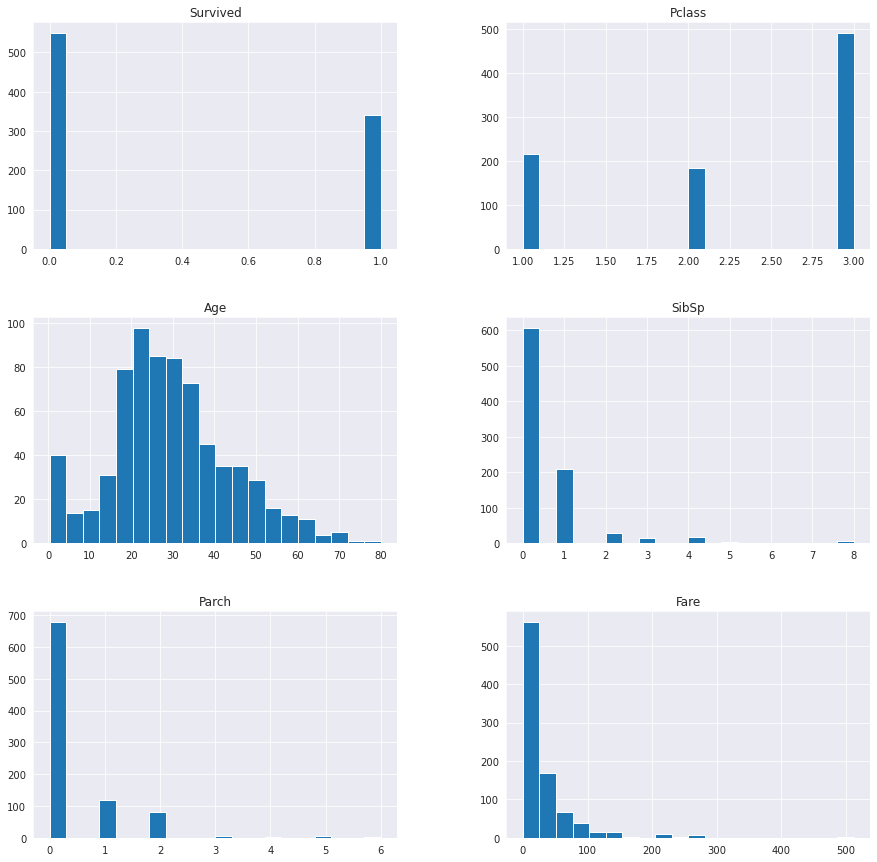

In [705]:
print(train_set.shape)
print(train_set.dtypes)
train_set.hist(bins=20, figsize=[15,15]);

Age histogram is left-skewed; median is a better measure of central tendency than mean. Other numeric features have a power-like distribution (perhaps a power transform would normalise them)

***Pivot table for categorical attributes***

In [706]:
# Custom function to pass as aggregator - returns proportions - same result as with 'crosstab'
func = lambda x: round(x.count()/train_set.shape[0],3)  
pivot1 = pd.pivot_table(train_set, index=['Sex'], columns = ['Pclass'], values='Survived', 
                        aggfunc=func, dropna=False, margins=True)
pivot1

Pclass,1,2,3,All
Sex,,,,
female,0.105,0.085,0.162,0.352
male,0.137,0.121,0.389,0.648
All,0.242,0.207,0.551,1.000


**Data grouping and boxplotting to reveal correlations between features that can inform data imputing strategy**

Pclass  Sex   
1       female    35.0
        male      40.0
2       female    28.0
        male      30.0
3       female    21.5
        male      25.0
Name: Age, dtype: float64

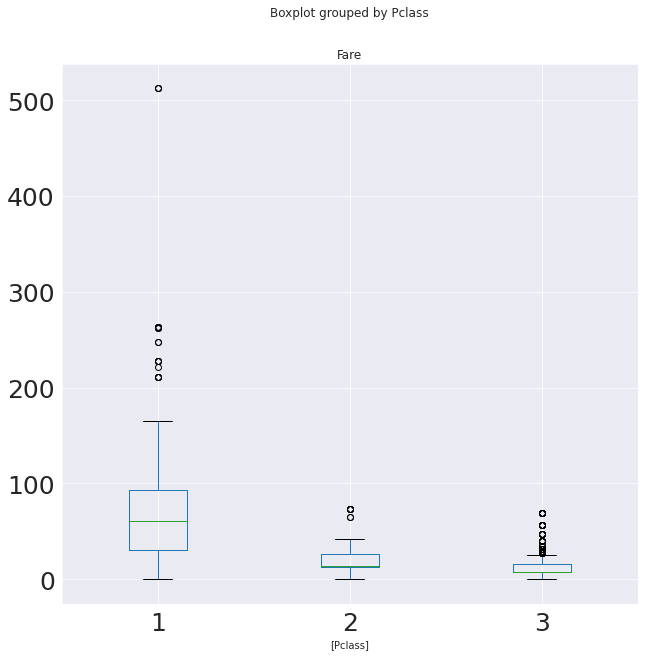

In [707]:
train_set.boxplot(column = 'Fare', by = ['Pclass'], figsize= (10, 10), fontsize = 25);
train_set.groupby(['Pclass','Sex']).Age.median()

Results show 'Age' is an increasing function of 'Pclass' (and 'Fare').
Also note there is one extreme outlier in the Fare data! Perhaps need to remove it

In [708]:
train_set[train_set["Fare"] > (train_set["Fare"].
                               quantile(0.75) + 4*(train_set["Fare"].quantile(0.75)-train_set["Fare"].
                                                   quantile(0.25)))].Fare.value_counts()

151.5500    4
227.5250    4
263.0000    4
135.6333    3
512.3292    3
153.4625    3
211.3375    3
133.6500    2
164.8667    2
146.5208    2
262.3750    2
247.5208    2
134.5000    2
221.7792    1
211.5000    1
Name: Fare, dtype: int64

Extreme fare values look to be legitimate values, won't remove

In [709]:
# Creating new feature reflecting size of passenger family

train_set['FamilySize'] = train_set['SibSp'] + train_set['Parch'] +1
x_test['FamilySize'] = x_test['SibSp'] + x_test['Parch'] +1

In [710]:
contig1 = pd.crosstab(train_set['Embarked'], train_set['Survived'], aggfunc=None, 
                margins=False, margins_name='All', dropna=False, normalize=False)
contig1

Survived,0,1
Embarked,,
C,75,93
Q,47,30
S,427,217


***Chi-squared indepedence test between categorical features and target***

In [711]:
from scipy import stats

cat_attr = ['Pclass','Sex','FamilySize','SibSp','Parch','Embarked']
def chi_test(attr):
    contig1 = pd.crosstab(train_set[attr], train_set['Survived'], aggfunc=None, 
                margins=False, margins_name='All', dropna=False, normalize=False)
    chi2, p, dof, ex = stats.chi2_contingency(contig1.to_numpy())
    print(f'{attr} and target:')
    print(f'chi2= {round(chi2,2)}; p-value= {p}; df = {dof}\n')
print("Chi-squared indepedence tests\n")
for attr in cat_attr:
    chi_test(attr)

Chi-squared indepedence tests

Pclass and target:
chi2= 102.89; p-value= 4.549251711298793e-23; df = 2

Sex and target:
chi2= 260.72; p-value= 1.1973570627755645e-58; df = 1

FamilySize and target:
chi2= 80.67; p-value= 3.579668975443533e-14; df = 8

SibSp and target:
chi2= 37.27; p-value= 1.5585810465902147e-06; df = 6

Parch and target:
chi2= 27.93; p-value= 9.703526421039997e-05; df = 6

Embarked and target:
chi2= 26.49; p-value= 1.769922284120912e-06; df = 2



We see that the engineered feature 'FamilySize' correlates better to Survival rate than singly siblings or parents/children. We'll be keeping this instead

***One-way ANOVA using Scipy***

In [712]:
# ANOVA tests measure correlation between categoricals and a numerical (target) variable

F, p = stats.f_oneway(train_set[train_set.Pclass == 2].Survived,
                     train_set[train_set.Pclass == 1].Survived,
                     train_set[train_set.Pclass == 3].Survived)

f'F-statistic: {round(F,2)}; p-value: {p}'

'F-statistic: 57.96; p-value: 2.1832474151179777e-24'

***Test independence between 'Pclass' and 'Fare'***

In [713]:
F, p = stats.f_oneway(train_set[train_set.Pclass == 2].Fare,
                     train_set[train_set.Pclass == 1].Fare,
                     train_set[train_set.Pclass == 3].Fare)

f'F-statistic: {round(F,2)}; p-value: {p}'

'F-statistic: 242.34; p-value: 1.0313763209142051e-84'

There is strong correlation between 'Pclass' and 'Fare'; this has to be properly handled in the estimator

**DATA CLEANING & FEATURE ENGINEERING**
1. Approach A (naive): Drop 'Cabin', 'Ticket', 'Name'; impute 'Age','Fare' with median, 'Embarked' with most_frequent; One-hot-encode 'Sex,'Embarked','Pclass'; center-scale 'Age', power-transform 'SibSp', 'Parch', 'Fare'
2. Approach B:  Drop 'Cabin', 'Ticket', 'Name', "SibSp","Parch"; 

In [714]:
train_1 = train_set.copy()

* **Data imputation**

In [715]:
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import SimpleImputer, KNNImputer, IterativeImputer

median_imputer = SimpleImputer(strategy="median")
mostFreq_imputer = SimpleImputer(strategy="most_frequent")
KNN_imputer = KNNImputer(n_neighbors=3)
iter_imputer = IterativeImputer()

**# Filling the missing values in Age with the medians of Sex and Pclass groups**


In [716]:
train_1['Age'] = train_1.groupby(['Sex', 'Pclass'])['Age'].transform(lambda x: x.fillna(x.median()))
x_test['Age'] = x_test.groupby(['Sex', 'Pclass'])['Age'].transform(lambda x: x.fillna(x.median()))

**# Filling the missing values in test set using test set statistics will result in **data leakage**! Address**

train_med_age_by_sex_pclass = train_1['Age'] = train_1.groupby(['Sex', 'Pclass'])['Age'].transform(lambda x: x.fillna(x.median()))

for pclass in train_1.Sex.unique():
    for sex in train_1.Pclass.unique():
        x_test.groupby(['Sex', 'Pclass'])['Age'].fillna(values = train_med_age_by_sex_pclass[sex][pclass]))

In [717]:
# Filling the missing value in 'Fare' column of test set
x_test['Fare'] = x_test.groupby(['Pclass'])['Fare'].transform(lambda x: x.fillna(x.median()))

* Discretization of continuous variables Fare and Age --> deals better with outliers

In [718]:
# Making Bins for 'Fare'
train_1['FareBin'] = pd.qcut(train_1['Fare'], 10, labels=False)
x_test['FareBin'] = pd.qcut(x_test['Fare'], 10, labels=False)

#label = LabelEncoder()
#train_1['FareBin_Code'] = label.fit_transform(train_1['FareBin'])

In [719]:
# Making Bins for 'Age'
train_1['AgeBin'] = pd.qcut(train_1['Age'], 10, labels=False)
x_test['AgeBin'] = pd.qcut(x_test['Age'], 10, labels=False)

In [720]:
# Binning FamilySize using a mapping function
family_map = {1: 'Alone', 2: 'Small', 3: 'Small', 4: 'Small', 5: 'Medium', 6: 'Medium', 7: 'Large', 8: 'Large', 11: 'Large'}
train_1['FamilySize_Binned'] = train_1['FamilySize'].map(family_map)
x_test['FamilySize_Binned'] = x_test['FamilySize'].map(family_map)

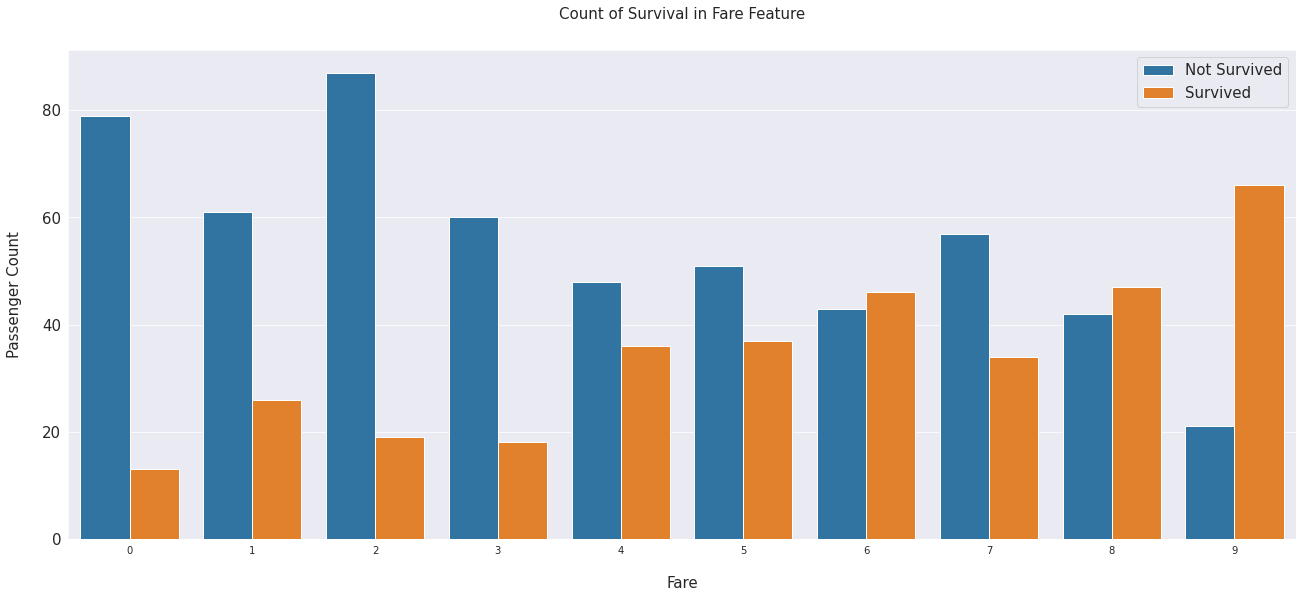

In [721]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_style("darkgrid")
fig, axs = plt.subplots(figsize=(22, 9))
sns.countplot(x='FareBin', hue='Survived', data=train_1)

plt.xlabel('Fare', size=15, labelpad=20)
plt.ylabel('Passenger Count', size=15, labelpad=20)
plt.tick_params(axis='x', labelsize=10)
plt.tick_params(axis='y', labelsize=15)

plt.legend(['Not Survived', 'Survived'], loc='upper right', prop={'size': 15})
plt.title('Count of Survival in {} Feature'.format('Fare'), size=15, y=1.05)

plt.show()

Engineer 'Family Survival Rate' feature

In [722]:
import string  

def extract_surname(data):    
    
    families = []
    
    for i in range(len(data)):        
        name = data.iloc[i]

        if '(' in name:
            name_no_bracket = name.split('(')[0] 
        else:
            name_no_bracket = name
            
        family = name_no_bracket.split(',')[0]
        title = name_no_bracket.split(',')[1].strip().split(' ')[0]
        
        for c in string.punctuation:
            family = family.replace(c, '').strip()
            
        families.append(family)
            
    return families

In [723]:
for dframe in [train_1, x_test]:
    dframe['Ticket_Frequency'] = dframe.groupby('Ticket')['Ticket'].transform('count')
    dframe['Title'] = dframe['Name'].str.split(', ', expand=True)[1].str.split('.', expand=True)[0]
    dframe['Is_Married'] = "N"
    dframe['Is_Married'].loc[dframe['Title'] == 'Mrs'] = "Y"
    dframe['Title'] = dframe['Title'].replace(['Miss', 'Mrs','Ms', 'Mlle', 'Lady', 'Mme', 'the Countess', 'Dona'], 'Miss/Mrs/Ms')
    dframe['Title'] = dframe['Title'].replace(['Dr', 'Col', 'Major', 'Jonkheer', 'Capt', 'Sir', 'Don', 'Rev'], 'Dr/Military/Noble/Clergy')
    dframe['Family'] = extract_surname(dframe['Name'])

/opt/conda/lib/python3.7/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


In [724]:
# Creating a list of families and tickets that are occuring in both training and test set
non_unique_families = [x for x in train_1['Family'].unique() if x in x_test['Family'].unique()]
non_unique_tickets = [x for x in train_1['Ticket'].unique() if x in x_test['Ticket'].unique()]

df_family_survival_rate = train_1.groupby('Family')['Survived', 'Family','FamilySize'].median()
df_ticket_survival_rate = train_1.groupby('Ticket')['Survived', 'Ticket','Ticket_Frequency'].median()

family_rates = {}
ticket_rates = {}

for i in range(len(df_family_survival_rate)):
    # Checking a family exists in both training and test set, and has members more than 1
    if df_family_survival_rate.index[i] in non_unique_families and df_family_survival_rate.iloc[i, 1] > 1:
        family_rates[df_family_survival_rate.index[i]] = df_family_survival_rate.iloc[i, 0]

for i in range(len(df_ticket_survival_rate)):
    # Checking a ticket exists in both training and test set, and has members more than 1
    if df_ticket_survival_rate.index[i] in non_unique_tickets and df_ticket_survival_rate.iloc[i, 1] > 1:
        ticket_rates[df_ticket_survival_rate.index[i]] = df_ticket_survival_rate.iloc[i, 0]

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:5: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  """
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  


In [725]:
mean_survival_rate = np.mean(train_1['Survived'])

train_family_survival_rate = []
train_family_survival_rate_NA = []
test_family_survival_rate = []
test_family_survival_rate_NA = []

for i in range(len(train_1)):
    if train_1['Family'].iloc[i] in family_rates:
        train_family_survival_rate.append(family_rates[train_1['Family'].iloc[i]])
        train_family_survival_rate_NA.append(1)
    else:
        train_family_survival_rate.append(mean_survival_rate)
        train_family_survival_rate_NA.append(0)
        
for i in range(len(x_test)):
    if x_test['Family'].iloc[i] in family_rates:
        test_family_survival_rate.append(family_rates[x_test['Family'].iloc[i]])
        test_family_survival_rate_NA.append(1)
    else:
        test_family_survival_rate.append(mean_survival_rate)
        test_family_survival_rate_NA.append(0)
        

In [726]:
train_1['Family_Survival_Rate'] = train_family_survival_rate
train_1['Family_Survival_Rate_NA'] = train_family_survival_rate_NA
x_test['Family_Survival_Rate'] = test_family_survival_rate
x_test['Family_Survival_Rate_NA'] = test_family_survival_rate_NA

train_ticket_survival_rate = []
train_ticket_survival_rate_NA = []
test_ticket_survival_rate = []
test_ticket_survival_rate_NA = []

for i in range(len(train_1)):
    if train_1['Ticket'].iloc[i] in ticket_rates:
        train_ticket_survival_rate.append(ticket_rates[train_1['Ticket'].iloc[i]])
        train_ticket_survival_rate_NA.append(1)
    else:
        train_ticket_survival_rate.append(mean_survival_rate)
        train_ticket_survival_rate_NA.append(0)

for i in range(len(x_test)):
    if x_test['Ticket'].iloc[i] in ticket_rates:
        test_ticket_survival_rate.append(ticket_rates[x_test['Ticket'].iloc[i]])
        test_ticket_survival_rate_NA.append(1)
    else:
        test_ticket_survival_rate.append(mean_survival_rate)
        test_ticket_survival_rate_NA.append(0)
        
train_1['Ticket_Survival_Rate'] = train_ticket_survival_rate
train_1['Ticket_Survival_Rate_NA'] = train_ticket_survival_rate_NA
x_test['Ticket_Survival_Rate'] = test_ticket_survival_rate
x_test['Ticket_Survival_Rate_NA'] = test_ticket_survival_rate_NA

In [727]:
for df in [train_1, x_test]:
    df['Survival_Rate'] = (df['Ticket_Survival_Rate'] + df['Family_Survival_Rate']) / 2
    df['Survival_Rate_NA'] = (df['Ticket_Survival_Rate_NA'] + df['Family_Survival_Rate_NA']) / 2   

In [728]:
labels_to_drop = ["Age","Fare","Cabin","Ticket","Name","SibSp","Parch",
                  "Ticket_Survival_Rate","Family","Is_Married",
                  "Family_Survival_Rate","Ticket_Survival_Rate_NA",
                  "Family_Survival_Rate_NA"]

for dframe in [train_1, x_test]:
    dframe.drop(labels_to_drop, 1, inplace=True)

**Categorical features encoding**

In [729]:
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder

one_hot_encoder = OneHotEncoder(handle_unknown="ignore")

In [730]:
# Split predictor and target attributes

y_train = train_1["Survived"]
x_train = train_1.drop(labels="Survived", axis=1, inplace=False)

In [731]:
numeric_features = x_train.select_dtypes(include=np.number).columns.tolist()
numeric_features

['Pclass',
 'FamilySize',
 'FareBin',
 'AgeBin',
 'Ticket_Frequency',
 'Survival_Rate',
 'Survival_Rate_NA']

In [732]:
x_train["FamilySize_Binned"].value_counts()

Alone     537
Small     292
Medium     37
Large      25
Name: FamilySize_Binned, dtype: int64

**TRANSFORMATION PIPELINES**

In [733]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, MinMaxScaler, PowerTransformer, LabelEncoder

categorical_attrs = ["Sex", "Title","FamilySize_Binned"]
age_pipe = Pipeline([('std_scaler', StandardScaler())])

embarked_pipe = Pipeline([
    ('imputer', mostFreq_imputer),
    ('one_hot', one_hot_encoder)
])

familySize_pipe = Pipeline([
    ("lblCode", LabelEncoder()),
    ("stdScaler", StandardScaler())   
])

full_pipe = ColumnTransformer([
    ("embarked", embarked_pipe, ["Embarked"]),
    ("cat_1hot",one_hot_encoder, categorical_attrs),
    ("stdScaler", StandardScaler(), numeric_features)
])

x_train_prep = full_pipe.fit_transform(x_train)
num_fitted_attrs = x_train_prep.shape[1]
print(f'Number of encoded features = {num_fitted_attrs}')

***MODEL TRAINING WITH HYPERPARAMETER TUNING***

We'll try Logistic Regression (SGD), Random Forests, KNN, SVM, XGBoost

In [734]:
from sklearn.linear_model import LogisticRegression, SGDClassifier
from xgboost import XGBClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

log_model = LogisticRegression(random_state=42, penalty='elasticnet', l1_ratio=0.5
                               , solver='saga', max_iter=5000)

forest_clf = RandomForestClassifier(random_state=42, oob_score=True,
                                    min_samples_leaf=5, min_samples_split=4)
KNN_clf = KNeighborsClassifier(algorithm='auto')
Xgb_clf = XGBClassifier()
SVM_clf = SVC()

# Set learning model
fit_model = Xgb_clf

# Full pipeline including model fitting
fitting_pipe = Pipeline([
    ('prep', full_pipe),
    ('fit_model', fit_model)
])

In [735]:
from sklearn.model_selection import GridSearchCV

# hyperparameter tuning for Random Forests
grid_rfor =[{'fit_model__bootstrap': [True,False],'fit_model__n_estimators': [80, 90, 100, 110],
             'fit_model__max_features': ['auto'], 'fit_model__max_depth':[10, 15, 20]
            }      
]

# hyperparameter tuning for KNN
n_neighbors = [6,7,8,9,10,11,12,14,16,18,20,22]
weights = ['uniform', 'distance']
leaf_size = list(range(1,50,5))
grid_KNN = [{'fit_model__weights': weights, 
            'fit_model__leaf_size': leaf_size, 
            'fit_model__n_neighbors': n_neighbors}]

# hyperparameter tuning for XGB
grid_xgb =[{'fit_model__learning_rate': [0.005, 0.01, 0.05, 0.1, 1]}
]

# hyperparameter tuning for SVC
grid_SVC = [{'fit_model__kernel': ["linear", "poly", "rbf"], 
            'fit_model__degree': [2, 3], 
            'fit_model__C': [0.01, 0.1, 0.5, 1.0, 5.0, 10.0]}
]


# Set GridSearch parameter space
param_grid = grid_xgb

Parameter grid space for log regression:
{'fitting__C': [0.01, 0.05, 0.1, 1, 10, 100], 
             'fitting__l1_ratio': [0, 0.25, 0.5, 0.75, 1]},

In [736]:
from sklearn.model_selection import StratifiedKFold, cross_val_predict

cv_strat = StratifiedKFold(n_splits=5)

# train across 5 folds, that's a total of 30*5=150 rounds of training 
grid_search = GridSearchCV(fitting_pipe, param_grid, cv=cv_strat,
                           scoring='roc_auc',
                           return_train_score=True,
                           verbose=True)

grid_search.fit(x_train, y_train);

Fitting 5 folds for each of 36 candidates, totalling 180 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 180 out of 180 | elapsed:   12.4s finished


In [737]:
# report optimisation results
print(grid_search.best_params_)
print(grid_search.best_score_)
best_estimator = grid_search.best_estimator_

{'fit_model__C': 10.0, 'fit_model__degree': 2, 'fit_model__kernel': 'poly'}
0.903065052434289


feature_names = ['x1_1', 'x1_2', 'x1_3', 'x0_female', 'x0_male', 'Age', 'SibSp', 'Parch', 'Fare', 'C', 'Q', 'S']
feature_importances = zip(feature_names, best_estimator.steps[1][1].feature_importances_)
sorted_importances = sorted(feature_importances, key=lambda x: x[1], reverse = True)

print("Feature relative importance")
for feat in sorted_importances:
    print("{:10}: {:04.3f}".format(feat[0],feat[1]))


In [738]:
from sklearn.metrics import confusion_matrix,precision_score, recall_score, f1_score, precision_recall_curve, roc_auc_score
from sklearn.model_selection import cross_val_predict, cross_val_score

y_pred = cross_val_predict(best_estimator, x_train, y_train, cv=cv_strat)
conf_mat = confusion_matrix(y_train, y_pred)
print(conf_mat)

print(f'F1-score:{f1_score(y_train, y_pred)}')
print(f'ROC-AUC score:{roc_auc_score(y_train, y_pred)}')

[[497  52]
 [ 89 253]]
F1-score:0.7820710973724885
ROC-AUC score:0.8225242066915924


In [743]:
best_score = cross_val_score(best_estimator, x_train, y_train, scoring='accuracy', cv=cv_strat)
best_score.mean()

0.8417550687339149

**TEST SET EVALUATION**

In [740]:
predictions = best_estimator.predict(x_test)

In [741]:
#x_test.index
output = pd.DataFrame({'PassengerId': x_test.index, 'Survived': predictions})
output.to_csv('my_submission.csv', index=False)
print("Your submission was successfully saved!")

Your submission was successfully saved!


In [742]:
output.head()

,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,1


**Validation accuracy comparison**

Best Random Forest: 0.821
KNN: 0.819
SVC: 0.822

**With 'Family Survival Rate', 'Is_Married', 'Title', 'FamilySize_Binned' and 'Ticket_Frequency' attributes**

Random Forest: 0.843
SVC: 0.842